In [1]:
import os
import site
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/braindecode/')
os.sys.path.insert(0, '/home/schirrmr/code/auto-diagnosis/')
os.sys.path.insert(0, '/home/schirrmr/code/adamw-evaluation/')
os.sys.path.insert(0, '/home/schirrmr/code/explaining/decomposition/')
%cd /home/schirrmr/

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)


/home/schirrmr


In [2]:
from braindecode.torch_ext.util import np_to_var
import scipy.signal
from braindecode.torch_ext.util import set_random_seeds
import numpy as np
from numpy.random import  RandomState
import torch as th
import torch.nn as nn
from braindecode.torch_ext.modules import Expression
from torch import optim
from braindecode.torch_ext.util import  np_to_var, var_to_np

In [63]:
from reversible import (ReversibleBlock, SubsampleSplitter, invert, 
                       sample_mixture_gaussian, get_weights_per_sample, sizes_from_weights,
                       multi_directions_gaussian_cdfs,
                       transform_gaussian_by_dirs, sample_directions,
                       norm_and_var_directions, sample_directions,
                        projected_samples_mixture_sorted,
                        sample_transport_loss,
                       train_epoch, init_model_params, get_inputs_from_reverted_samples)
from braindecode.datautil.iterators import get_balanced_batches
from reversible import sampled_energy_transport_loss
from IPython.display import display

### only the same example all the time

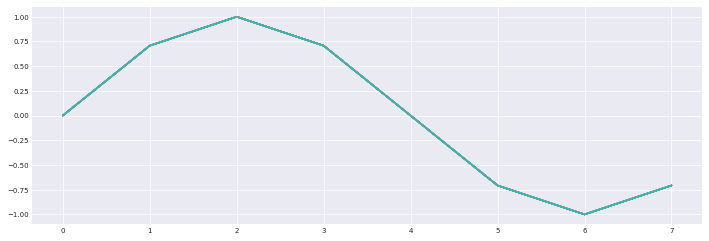

In [4]:
n = 1000
sins = np.repeat(np.sin(np.linspace(0, 2*np.pi, 8, endpoint=False))[None], (n), axis=0)

rng = RandomState(3847384)
plt.plot(sins[:10].T);

In [58]:
def rev_block(chans, intermediate_chans):
    c = chans // 2
    n_i_c = intermediate_chans
    return ReversibleBlock(
        nn.Sequential(
            (nn.Conv2d(c, n_i_c,(3,1), stride=1, padding=(1,0),bias=True)),
             #nn.BatchNorm2d(n_i_c),
             nn.ReLU(),
             nn.Conv2d(n_i_c, c,(1,1), stride=1, padding=0,bias=True)),
        nn.Sequential(
            (nn.Conv2d(c, n_i_c,(3,1), stride=1, padding=(1,0),bias=True)),
             #nn.BatchNorm2d(n_i_c),
             nn.ReLU(),
             nn.Conv2d(n_i_c,c,(1,1), stride=1, padding=0,bias=True)),)


In [61]:
set_random_seeds(34093049, False)
feature_model = nn.Sequential(
    SubsampleSplitter((2,1)),
    rev_block(2,3),
    rev_block(2,3),
    rev_block(2,3),
    SubsampleSplitter((2,1)),
    rev_block(4,5),
    rev_block(4,5),
    rev_block(4,5),
    SubsampleSplitter((2,1)),
    rev_block(8,8),
    rev_block(8,8),
    rev_block(8,8),
)
init_model_params(feature_model, 1)

n_dims = 8
n_clusters = 1
means_per_dim = th.autograd.Variable(th.randn(n_clusters,n_dims) * 0.05, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.rand(n_clusters,n_dims)  + 0.2, requires_grad=True)
weights_per_cluster = th.autograd.Variable(th.ones(n_clusters), requires_grad=True)
optimizer = optim.Adam(list(feature_model.parameters()) + 
                       [means_per_dim, stds_per_dim, weights_per_cluster],
                       lr=0.001)

directions_adv = th.cat([sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

optimizer_adv = optim.Adam([directions_adv], lr=0.001)
inputs = np_to_var(sins, dtype=np.float32).unsqueeze(1).unsqueeze(3)


rec_examples = get_inputs_from_reverted_samples(
    len(inputs),means_per_dim, stds_per_dim, weights_per_cluster, feature_model)
np.std(rec_examples)

1.8592002

In [62]:
import pandas as pd
rng = RandomState(1)
batch_size = 128
epochs_dataframe = pd.DataFrame()
for i_epoch in range(201):
    feature_model.train()
    all_trans_losses, all_l1_losses, all_losses = train_epoch(
        inputs, batch_size, rng, feature_model,
        means_per_dim,stds_per_dim, weights_per_cluster,
        directions_adv,
        optimizer, optimizer_adv,
        std_l1=0.5, mean_l1=0.01, weight_l1=0,
        backprop_sample_loss_to_cluster_weights=False)
    feature_model.eval()

    rec_examples = get_inputs_from_reverted_samples(
        len(inputs),means_per_dim, stds_per_dim, weights_per_cluster, feature_model)
    unmeaned_rec_examples = rec_examples - np.mean(rec_examples, axis=1, keepdims=True)
    unmeaned_inputs = var_to_np(inputs).squeeze() - np.mean(var_to_np(inputs).squeeze(), axis=1, keepdims=True)
    corrs = np.mean(unmeaned_rec_examples * unmeaned_inputs, axis=1,keepdims=True) / (
        np.std(rec_examples, axis=1, keepdims=True) * np.std(unmeaned_inputs, axis=1, keepdims=True))
    corr = np.mean(corrs)
    abs_diff = np.mean(np.abs(rec_examples - var_to_np(inputs).squeeze()))
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(all_losses),
        'l1_loss': np.mean(all_l1_losses),
        'trans_loss': np.mean(all_trans_losses),
        'corr': corr,
        'diff': abs_diff},
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])


corr      diff   l1_loss  total_loss  trans_loss
0  0.101115  1.546711  0.346688     5.24363    4.896943

corr      diff  l1_loss  total_loss  trans_loss
10  0.38629  1.146738  0.30276    2.293563    1.990803

corr      diff   l1_loss  total_loss  trans_loss
20  0.484848  0.976011  0.260775     2.06303    1.802254

corr      diff   l1_loss  total_loss  trans_loss
30  0.515099  0.872859  0.221375    1.829033    1.607658

corr      diff  l1_loss  total_loss  trans_loss
40  0.540765  0.791497  0.18396    1.590902    1.406942

corr      diff   l1_loss  total_loss  trans_loss
50  0.615641  0.665285  0.148481    1.365248    1.216767

corr      diff   l1_loss  total_loss  trans_loss
60  0.722568  0.542025  0.115223    1.131042     1.01582

corr      diff   l1_loss  total_loss  trans_loss
70  0.792186  0.445463  0.087431    0.914037    0.826606

corr      diff   l1_loss  total_loss  trans_loss
80  0.873351  0.345299  0.062475    0.683373    0.620898

corr      diff   l1_loss  total_loss  trans_loss
90  0.960501  0.224936  0.041426    0.465021    0.423595

corr      diff   l1_loss  total_loss  trans_loss
100  0.992315  0.118363  0.021704    0.249001    0.227296

corr      diff   l1_loss  total_loss  trans_loss
110  0.999927  0.012449  0.003162    0.043693    0.040531

corr      diff   l1_loss  total_loss  trans_loss
120  0.999986  0.005755  0.000514    0.027707    0.027193

corr     diff   l1_loss  total_loss  trans_loss
130  0.999999  0.00116  0.000508    0.017461    0.016953

corr      diff   l1_loss  total_loss  trans_loss
140  0.999999  0.000891  0.000503    0.013324    0.012821

corr      diff   l1_loss  total_loss  trans_loss
150  0.999999  0.000969  0.000498    0.011508    0.011009

corr      diff   l1_loss  total_loss  trans_loss
160  0.999999  0.001199  0.000494     0.01057    0.010076

corr      diff  l1_loss  total_loss  trans_loss
170  0.999999  0.000787  0.00049     0.00979    0.009301

corr      diff   l1_loss  total_loss  trans_loss
180  0.999998  0.001126  0.000485    0.008905     0.00842

corr      diff   l1_loss  total_loss  trans_loss
190  0.999998  0.001126  0.000482    0.007697    0.007215

corr      diff   l1_loss  total_loss  trans_loss
200  0.999999  0.001025  0.000479    0.006798    0.006319

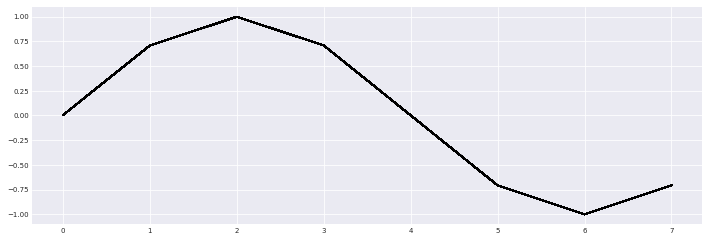

In [65]:
plt.plot(rec_examples.T, color='black', alpha=0.2);

In [34]:
# for gain = 1
# 1.58215
# 0.0908873627323

# for gain = 0.1
# 0.917994
# 0.0297651189237

# for gain =  0.01
# 0.918195
# 0.0289020658546

# for gain =  0.001
# 0.918197
# 0.0288934330705

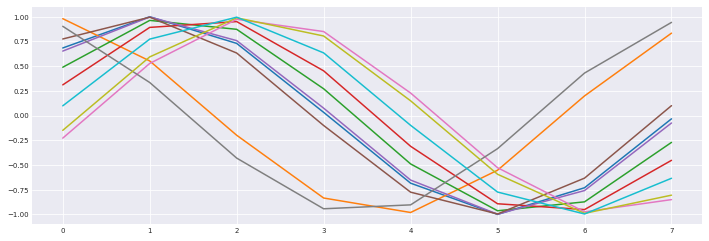

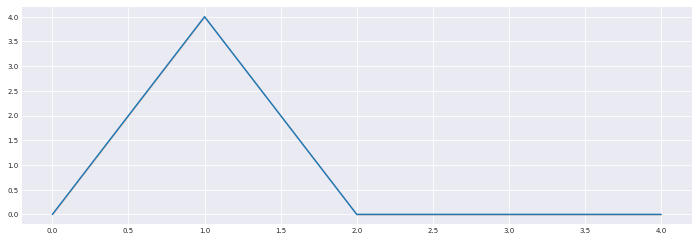

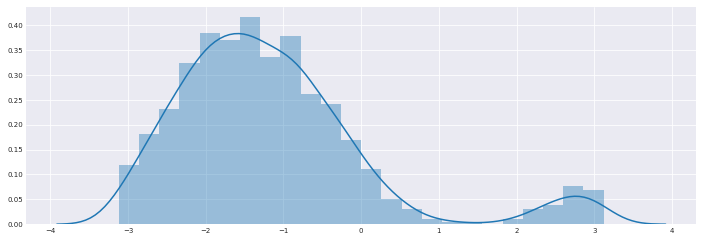

In [66]:
n = 1000
rng = RandomState(3847384)
phases = rng.randn(n)
sins = [np.sin(np.linspace(0, 2*np.pi, 8, endpoint=False) + p) for p in phases]
sins = np.array(sins)

plt.figure()
plt.plot(sins[:10].T);
bps = np.abs(np.fft.rfft(sins, axis=1))
plt.figure()
plt.plot(np.mean(bps, axis=0));
plt.fill_between(range(5), np.mean(bps, axis=0) - np.std(bps, axis=0),
                        np.mean(bps, axis=0) + np.std(bps, axis=0), alpha=0.2,
                        color=seaborn.color_palette()[1])
mean_bps = np.mean(bps, axis=0)
std_bps = np.std(bps, axis=0)
phases = np.angle(np.fft.rfft(sins, axis=1))
plt.figure()
seaborn.distplot(phases[:,1])
plt.figure()
plt.plot(sins.T, color='black', alpha=0.2);
plt.title("Real examples", fontsize=16)
bps_orig = np.abs(np.fft.rfft(sins, axis=1))
mean_bps_orig = np.mean(bps_orig, axis=0)
std_bps_orig = np.std(bps_orig, axis=0)
phases_orig = np.angle(np.fft.rfft(sins, axis=1))
sorted_phases_orig = np.sort(phases_orig[:,1])

In [94]:
set_random_seeds(34093049, False)
feature_model = nn.Sequential(
    SubsampleSplitter((2,1)),
    rev_block(2,3),
    rev_block(2,3),
    rev_block(2,3),
    SubsampleSplitter((2,1)),
    rev_block(4,5),
    rev_block(4,5),
    rev_block(4,5),
    SubsampleSplitter((2,1)),
    rev_block(8,8),
    rev_block(8,8),
    rev_block(8,8),
)
init_model_params(feature_model, 1)

n_dims = 8
n_clusters = 1
means_per_dim = th.autograd.Variable(th.randn(n_clusters,n_dims) * 0.05, requires_grad=True)
stds_per_dim = th.autograd.Variable(th.rand(n_clusters,n_dims)  + 0.2, requires_grad=True)
weights_per_cluster = th.autograd.Variable(th.ones(n_clusters), requires_grad=True)
optimizer = optim.Adam(list(feature_model.parameters()) + 
                       [means_per_dim, stds_per_dim, weights_per_cluster],
                       lr=0.001)

directions_adv = th.cat([sample_directions(n_dims, True,False),
                         sample_directions(n_dims, True,False),
                        ],dim=0)
directions_adv = th.autograd.Variable(directions_adv.data, requires_grad=True)

optimizer_adv = optim.Adam([directions_adv], lr=0.001)
inputs = np_to_var(sins, dtype=np.float32).unsqueeze(1).unsqueeze(3)


rec_examples = get_inputs_from_reverted_samples(
    len(inputs),means_per_dim, stds_per_dim, weights_per_cluster, feature_model)
np.std(rec_examples)

1.8592002

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
0  4.279247  0.346699    0.119048    3.682936    3.336237

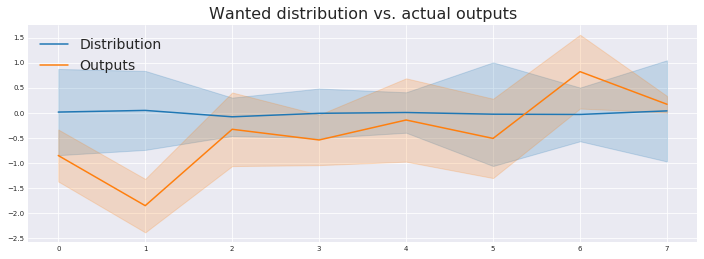

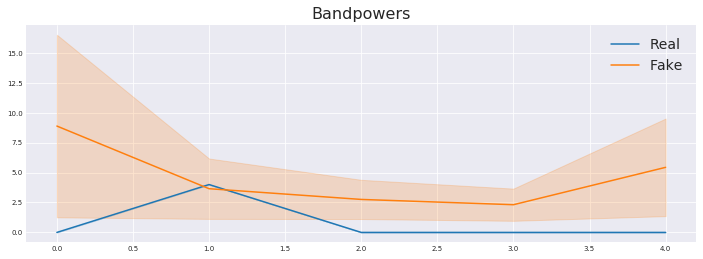

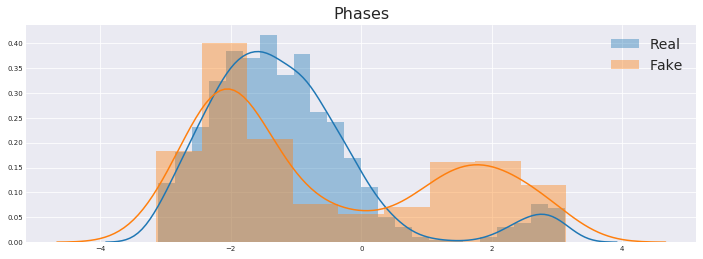

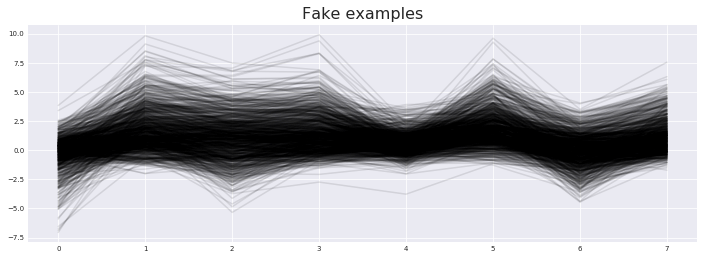

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
10  2.626856  0.303074    0.087535    1.263193    0.960119

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
20  2.479838  0.262677    0.064617    0.938358    0.675681

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
30  2.348764  0.225364    0.056341    0.765446    0.540082

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
40  1.994506  0.193638    0.051885    0.657917     0.46428

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
50   1.6777  0.163884    0.049975    0.576647    0.412763

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
60  1.380432  0.136551    0.058251    0.490674    0.354123

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
70  1.094157  0.114121    0.064299    0.397457    0.283336

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
80  0.835856  0.093365      0.0678    0.342698    0.249333

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
90  0.683738  0.077395    0.066208    0.278252    0.200857

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
100  0.555388  0.065822    0.075758    0.249501    0.183679

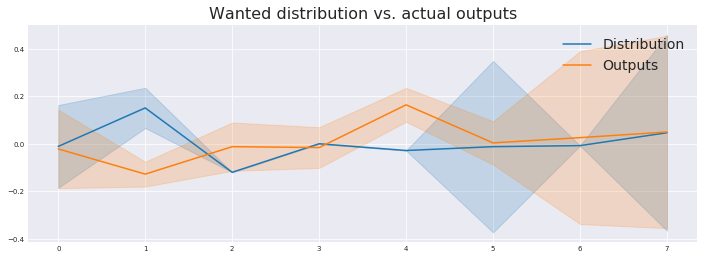

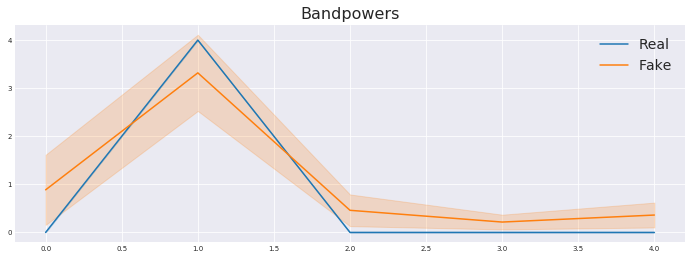

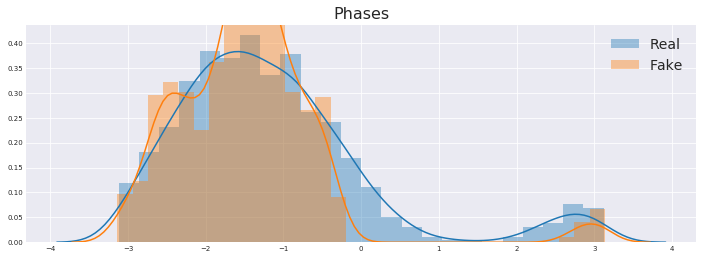

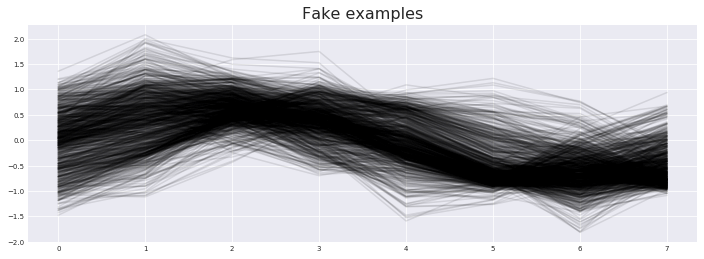

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
110  0.48828  0.055842    0.079259    0.219796    0.163954

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
120  0.381756  0.047373    0.078941    0.196631    0.149258

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
130  0.350328  0.04001    0.075758    0.157128    0.117118

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
140  0.330174  0.034075    0.080532    0.143644    0.109569

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
150  0.288316  0.029772    0.076394     0.12752    0.097749

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
160  0.271518  0.026087    0.069073    0.115407     0.08932

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
170  0.21924  0.022922      0.0678    0.109817    0.086895

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
180  0.206879  0.02015    0.070983    0.092027    0.071878

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
190  0.194862  0.018213    0.057296    0.081417    0.063205

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
200  0.178767  0.016659    0.061434    0.085574    0.068915

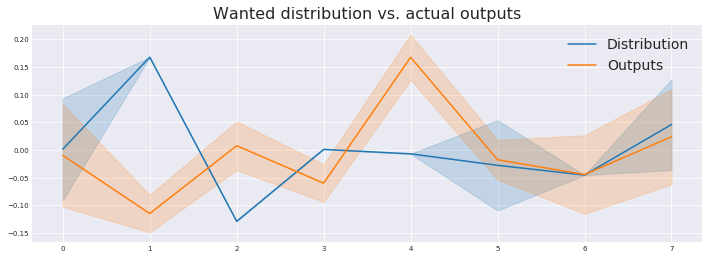

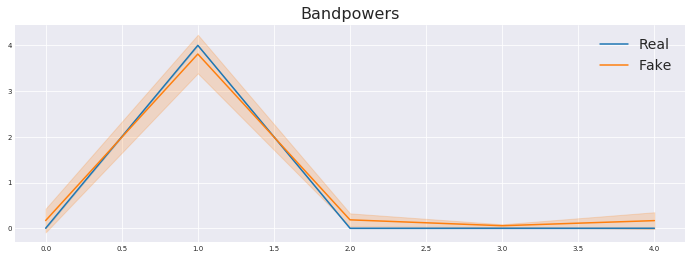

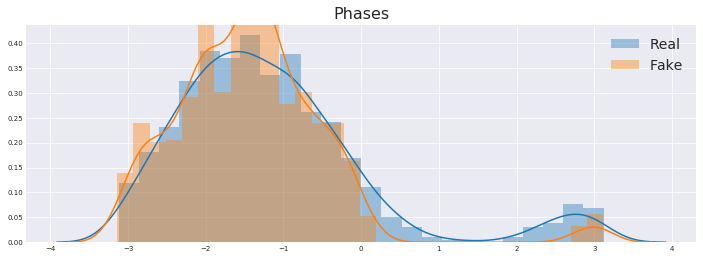

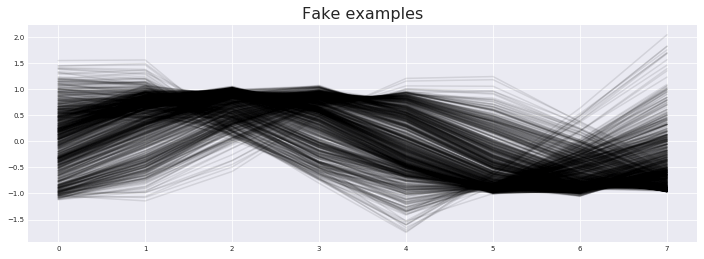

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
210  0.181486  0.015477    0.057932    0.074386    0.058909

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
220  0.160815   0.0145    0.058569    0.072427    0.057927

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
230  0.147439  0.013493    0.054431      0.0636    0.050107

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
240  0.164035  0.012866    0.054749    0.061951    0.049086

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
250  0.150757   0.0121    0.053794     0.06006     0.04796

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
260  0.144587  0.011395    0.052839    0.057468    0.046074

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
270  0.13244  0.010891    0.056659    0.057132    0.046241

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
280  0.135256  0.010424    0.054749    0.048863    0.038439

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
290  0.14862  0.009832    0.057296    0.053462     0.04363

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
300  0.122908  0.009493    0.056023    0.046228    0.036735

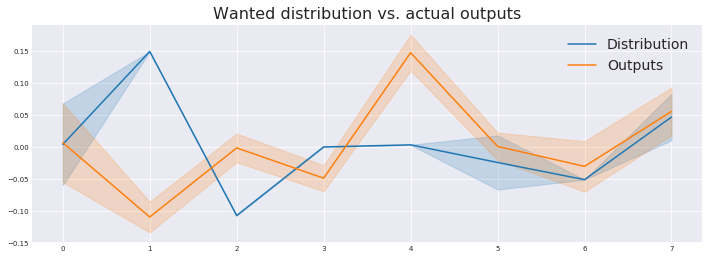

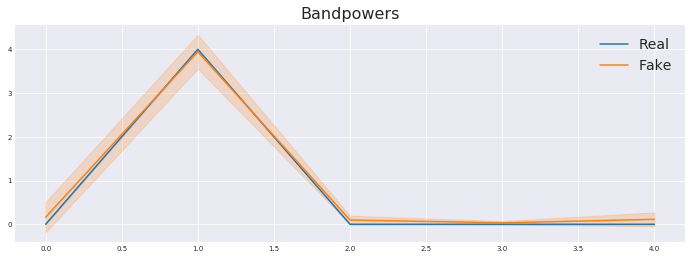

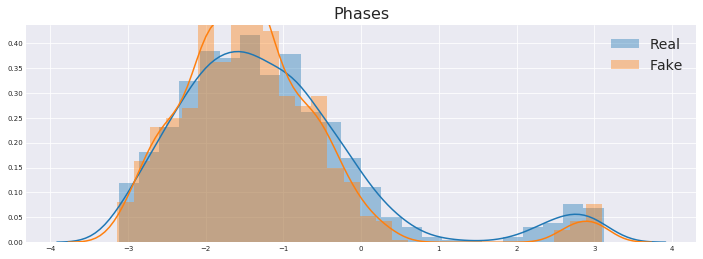

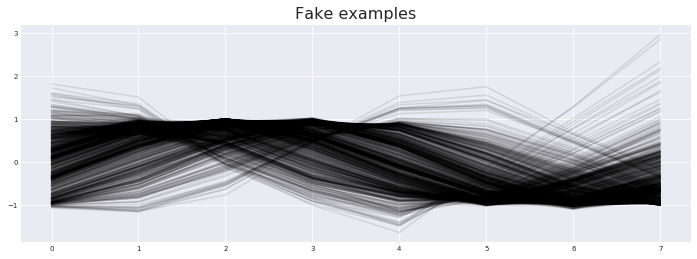

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
310  0.121222  0.009438    0.052521    0.050366    0.040928

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
320  0.132688  0.008928    0.062707     0.04245    0.033522

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
330  0.126525  0.008854    0.056341    0.043336    0.034482

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
340  0.125007  0.008507    0.057296    0.043675    0.035168

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
350  0.124017  0.008539     0.05093    0.042664    0.034125

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
360  0.121553  0.00824    0.054431    0.043014    0.034775

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
370  0.122609  0.008128    0.045837    0.038706    0.030578

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
380  0.108294  0.007737    0.054749     0.04168    0.033942

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
390  0.114899  0.007662    0.043608    0.035762      0.0281

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
400  0.105276  0.00737    0.052839    0.037406    0.030036

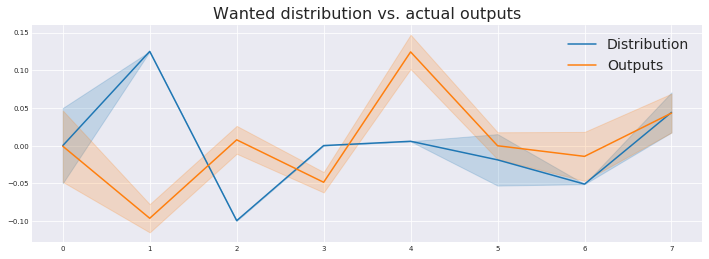

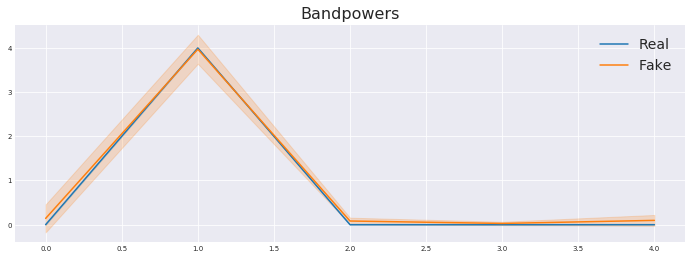

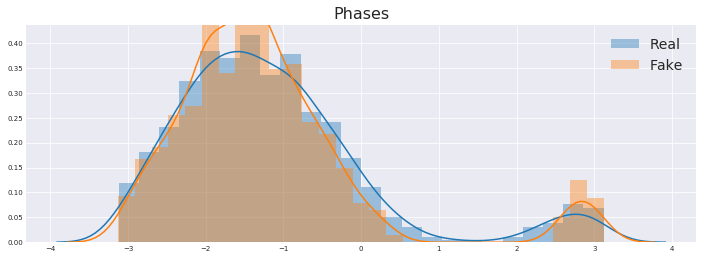

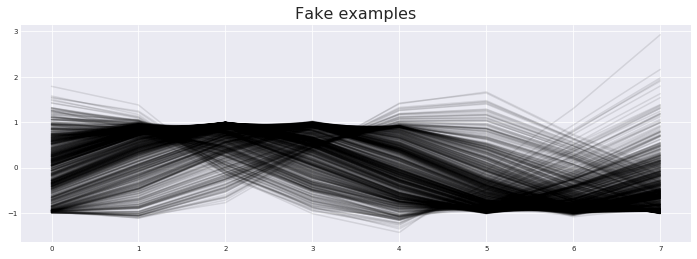

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
410  0.095551  0.007406    0.052839    0.039969    0.032562

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
420  0.096444  0.007071    0.052839    0.041693    0.034622

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
430  0.103616  0.007243    0.051566    0.039299    0.032056

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
440  0.102217  0.007038    0.056023    0.039316    0.032278

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
450  0.108762  0.00699    0.051885    0.040753    0.033763

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
460  0.088031  0.006896    0.047746    0.037088    0.030192

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
470  0.097739  0.006754    0.046473    0.038073    0.031319

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
480  0.095275  0.006548    0.054749    0.033469    0.026921

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
490  0.098369  0.006587    0.060479    0.038558    0.031972

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
500  0.111082  0.006397    0.049975    0.033738    0.027341

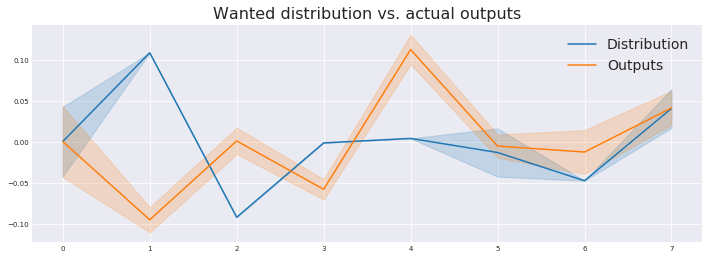

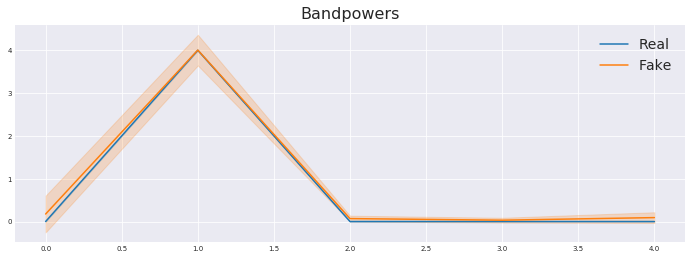

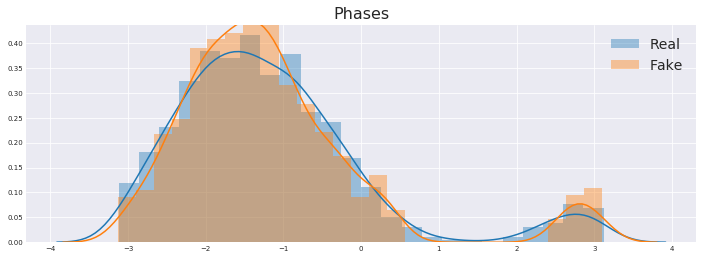

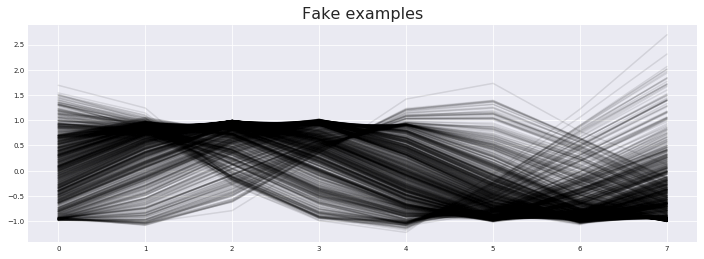

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
510  0.089306  0.006259    0.049338    0.036053    0.029794

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
520  0.088918  0.006163    0.055386    0.031591    0.025428

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
530  0.091363  0.005933    0.044245    0.032164    0.026231

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
540  0.081707  0.005911    0.052203    0.030332    0.024421

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
550  0.075982  0.005845    0.048383    0.033861    0.028016

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
560  0.078109  0.005659    0.053476     0.03378    0.028122

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
570  0.088793  0.006415    0.053158    0.035695    0.029281

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
580  0.090794  0.006465     0.05093    0.030406    0.023941

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
590  0.097807  0.006139    0.049656    0.027455    0.021315

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
600  0.08679  0.006352    0.054113     0.03528    0.028928

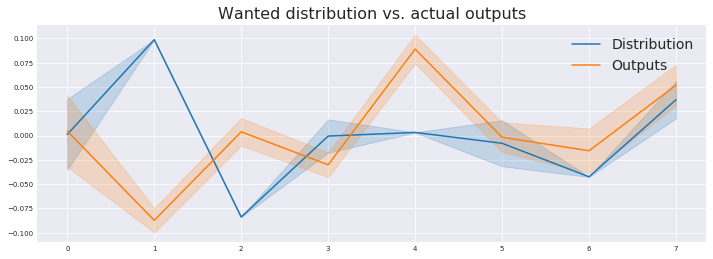

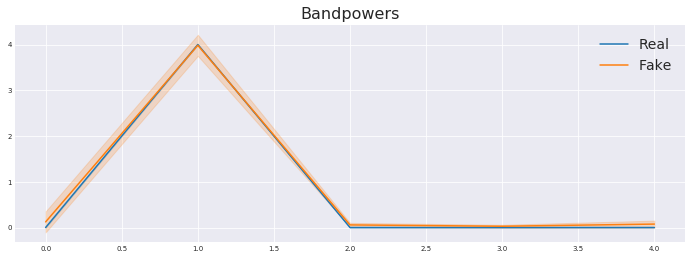

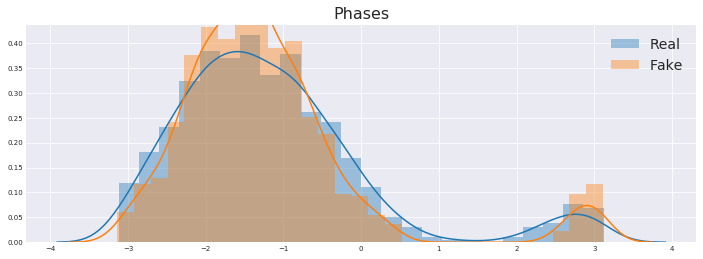

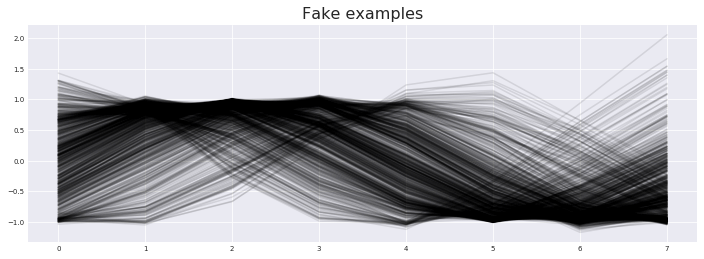

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
610  0.083035  0.005962    0.048065    0.029483    0.023521

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
620  0.080612  0.005929    0.060479    0.036277    0.030348

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
630  0.087718  0.006025    0.054749    0.034818    0.028794

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
640  0.088249  0.005845    0.043927    0.030055     0.02421

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
650  0.083895  0.006035    0.052203    0.033196    0.027162

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
660  0.086977  0.00568    0.049338    0.026648    0.020967

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
670  0.081722  0.005889    0.043927    0.026113    0.020225

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
680  0.088228  0.005654    0.045518    0.024498    0.018844

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
690  0.084524  0.005821     0.04711     0.02705     0.02123

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
700  0.074642  0.005649    0.053476    0.029314    0.023665

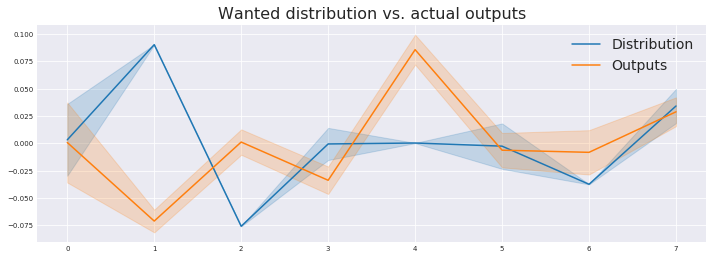

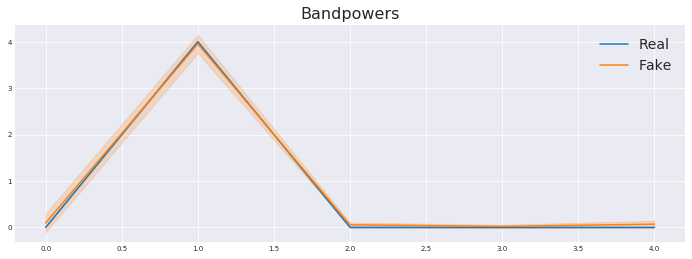

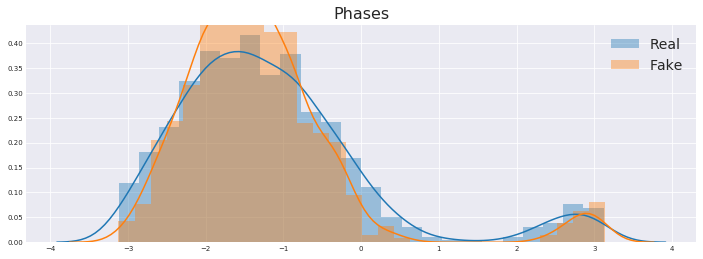

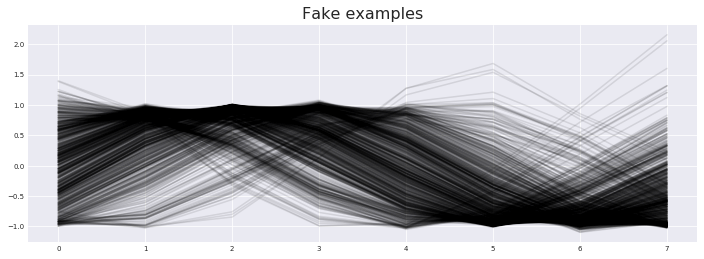

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
710  0.087734  0.005673    0.052203    0.030611    0.024938

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
720  0.087207  0.005711      0.0452    0.029379    0.023668

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
730  0.080462  0.005492    0.049975    0.033112     0.02762

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
740  0.084813  0.005502    0.052203    0.030619    0.025117

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
750  0.076914  0.00552    0.054431    0.027191    0.021671

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
760  0.085085  0.005216    0.051248    0.032791    0.027574

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
770  0.072767  0.005396    0.057614    0.029135    0.023738

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
780  0.068027  0.005408    0.053158    0.028034    0.022626

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
790  0.088314  0.005243    0.044563    0.026378    0.021135

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
800  0.082286  0.005442    0.051248    0.030214    0.024771

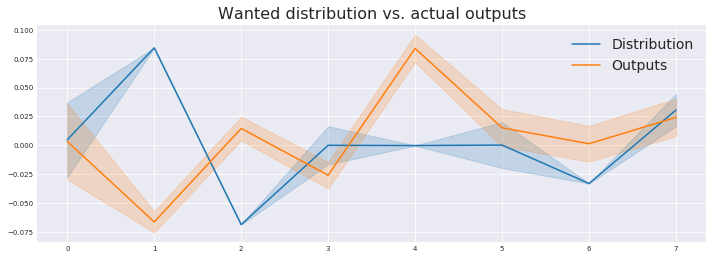

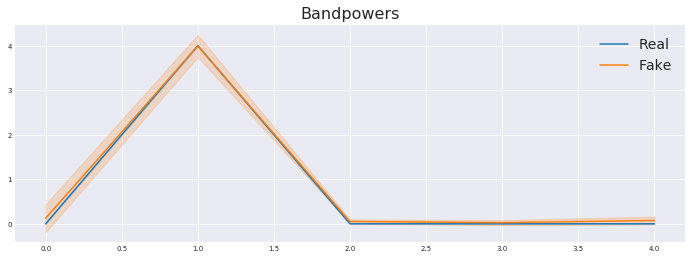

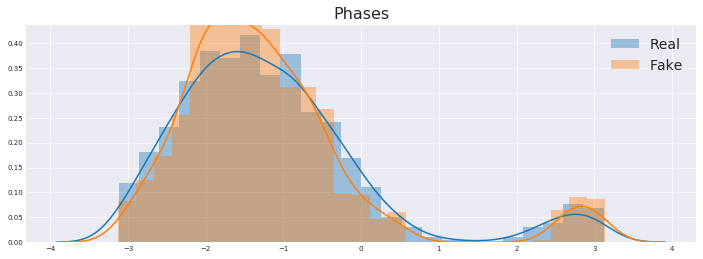

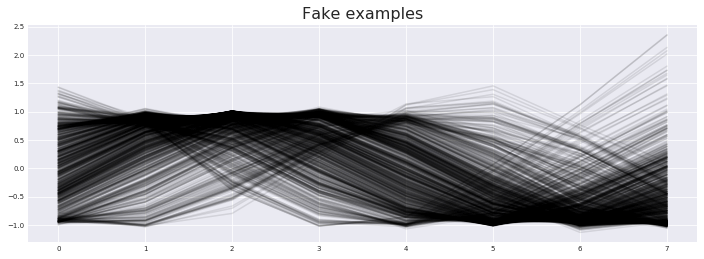

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
810  0.071234  0.005297    0.048065    0.030376    0.025079

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
820  0.07039  0.005225    0.052839    0.027777    0.022552

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
830  0.066589  0.005045    0.047746    0.024249    0.019204

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
840  0.073754  0.005051    0.054113    0.026233    0.021182

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
850  0.077148  0.005268    0.048065    0.024943    0.019675

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
860  0.106053  0.00544    0.052521    0.024419    0.018978

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
870  0.106806  0.005373    0.051248    0.027419    0.022046

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
880  0.09735  0.005154    0.055068    0.029091    0.023937

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
890  0.105987  0.005294    0.050611    0.025791    0.020497

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
900  0.111826  0.005881    0.044245     0.02921    0.023329

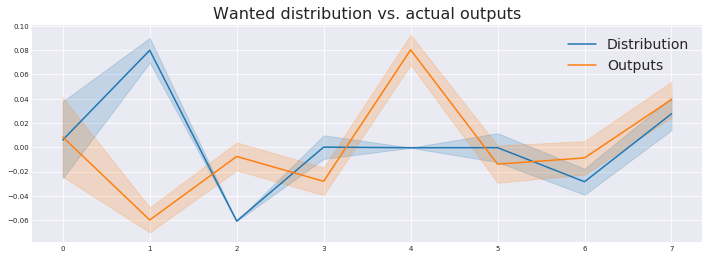

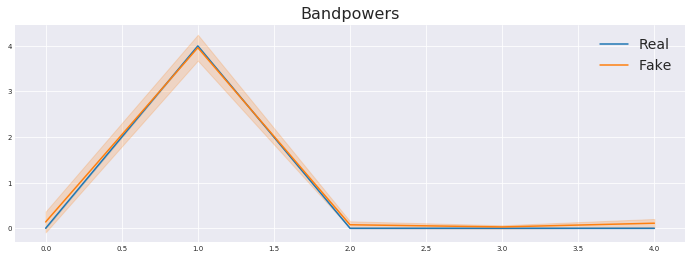

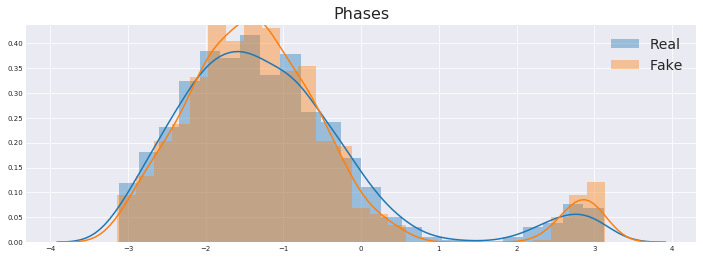

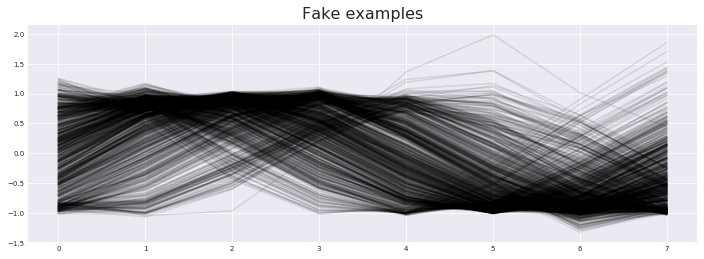

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
910  0.104879  0.005626    0.054749    0.025734    0.020108

bp_diff  l1_loss  phase_diff  total_loss  trans_loss
920  0.129605  0.00542    0.055068    0.024093    0.018673

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
930  0.113829  0.005059     0.05093    0.021889    0.016829

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
940  0.112256  0.005023    0.045837    0.023035    0.018012

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
950  0.120854  0.005185    0.050611    0.023237    0.018052

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
960  0.104766  0.004905    0.054113    0.029077    0.024172

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
970  0.114606  0.005075    0.048065    0.030937    0.025862

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
980  0.113195  0.004915    0.052839    0.021703    0.016787

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
990   0.1143  0.005024    0.047428    0.025362    0.020339

bp_diff   l1_loss  phase_diff  total_loss  trans_loss
1000  0.104332  0.004794    0.045837    0.022409    0.017614

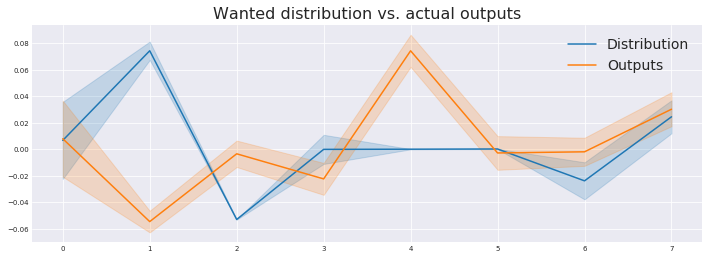

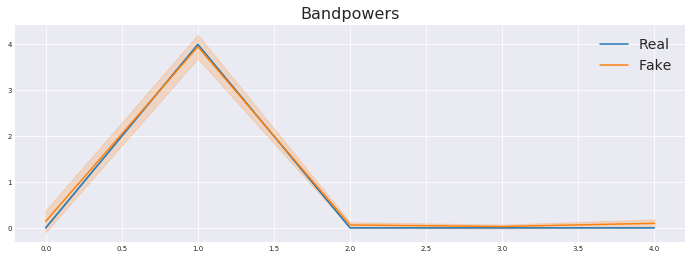

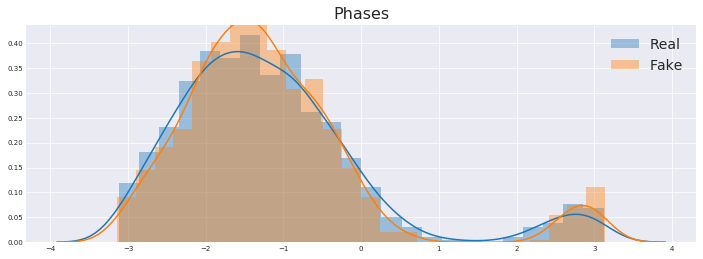

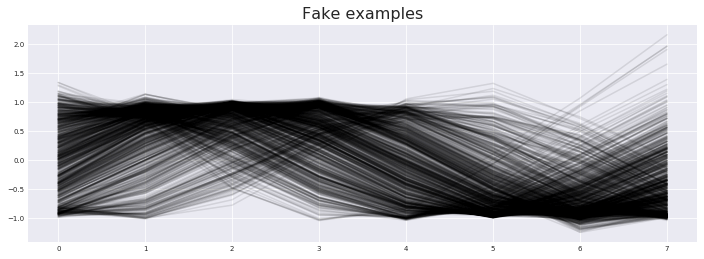

In [96]:
import pandas as pd
rng = RandomState(1)
batch_size = 128
epochs_dataframe = pd.DataFrame()
for i_epoch in range(1001):
    feature_model.train()
    all_trans_losses, all_l1_losses, all_losses = train_epoch(
        inputs, batch_size, rng, feature_model,
        means_per_dim,stds_per_dim, weights_per_cluster,
        directions_adv,
        optimizer, optimizer_adv,
        std_l1=0.5, mean_l1=0.01, weight_l1=0,
        backprop_sample_loss_to_cluster_weights=False)
    feature_model.eval()

    rec_examples = get_inputs_from_reverted_samples(
        len(inputs),means_per_dim, stds_per_dim, weights_per_cluster, feature_model)

    bps = np.abs(np.fft.rfft(rec_examples, axis=1))
    mean_bps = np.mean(bps, axis=0)
    std_bps = np.std(bps, axis=0)
    phases = np.angle(np.fft.rfft(rec_examples, axis=1))
    sorted_phases = np.sort(phases[:,1])


    histograms, _ = np.histogram(sorted_phases, bins=100, range=(-np.pi, np.pi), density=True)
    histograms_orig, _ = np.histogram(sorted_phases_orig, bins=100, range=(-np.pi, np.pi), density=True)
    phase_diff = np.mean(np.abs(histograms - histograms_orig))
    bp_diff = np.mean(np.abs(bps - bps_orig))
    
    epochs_dataframe = epochs_dataframe.append({
        'total_loss': np.mean(all_losses),
        'l1_loss': np.mean(all_l1_losses),
        'trans_loss': np.mean(all_trans_losses),
        'phase_diff': phase_diff,
        'bp_diff': bp_diff},
        ignore_index=True)
    if i_epoch % 10 == 0:
        display(epochs_dataframe.iloc[-1:])
    if i_epoch % 100 == 0:
        all_outs = feature_model(inputs)
        all_outs = th.cat((all_outs[:,::2], all_outs[:,1::2]), dim=1).squeeze()
        all_outs = var_to_np(all_outs)
        fig = plt.figure()
        plt.plot(var_to_np(means_per_dim).squeeze())
        plt.fill_between(range(8), var_to_np(means_per_dim).squeeze() - var_to_np(stds_per_dim).squeeze(),
                        var_to_np(means_per_dim).squeeze() + var_to_np(stds_per_dim).squeeze(), alpha=0.2,
                        color=seaborn.color_palette()[0])
        plt.plot(np.mean(all_outs, axis=0))
        plt.fill_between(range(8), np.mean(all_outs, axis=0) - np.std(all_outs, axis=0),
                        np.mean(all_outs, axis=0) + np.std(all_outs, axis=0), alpha=0.2,
                        color=seaborn.color_palette()[1])
        plt.title("Wanted distribution vs. actual outputs", fontsize=16)
        plt.legend(('Distribution', 'Outputs'), fontsize=14)
        display(fig)
        plt.close(fig)

        fig = plt.figure()
        plt.plot(np.mean(bps_orig, axis=0));
        plt.fill_between(range(5), np.mean(bps_orig, axis=0) - np.std(bps_orig, axis=0),
                                np.mean(bps_orig, axis=0) + np.std(bps_orig, axis=0), alpha=0.2,
                                color=seaborn.color_palette()[0])
        plt.plot(np.mean(bps, axis=0));
        plt.fill_between(range(5), np.mean(bps, axis=0) - np.std(bps, axis=0),
                                np.mean(bps, axis=0) + np.std(bps, axis=0), alpha=0.2,
                                color=seaborn.color_palette()[1])
        plt.title("Bandpowers", fontsize=16)
        plt.legend(('Real', 'Fake'), fontsize=14)
        display(fig)
        plt.close(fig)

        fig = plt.figure()
        seaborn.distplot(sorted_phases_orig)
        seaborn.distplot(sorted_phases)
        plt.title("Phases", fontsize=16)
        plt.legend(('Real', 'Fake'), fontsize=14)
        display(fig)
        plt.close(fig)

        fig = plt.figure()
        plt.plot(rec_examples.T, color='black', alpha=0.1);
        plt.title("Fake examples", fontsize=16)
        display(fig)
        plt.close(fig);

        

In [97]:
def plot_sorted_examples(sorted_examples, cmap=cm.ocean):
    plt.figure()
    cmap_lines = cmap(np.linspace(0,1, len(sorted_examples)).tolist())


    for i_example in range(len(sorted_examples)):
        plt.plot(sorted_examples[i_example], color=cmap_lines[i_example], alpha=0.2)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
        vmin=np.min(var_to_np(gauss_samples)[:, i_feature]),
        vmax=np.max(var_to_np(gauss_samples)[:, i_feature]),))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    plt.colorbar(sm)

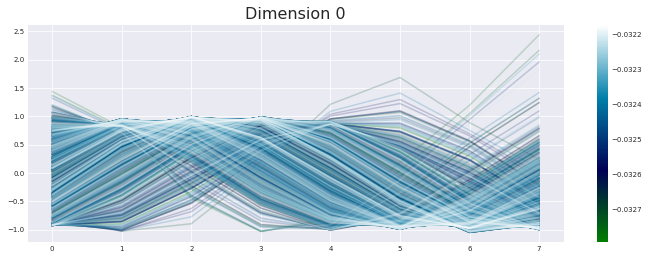

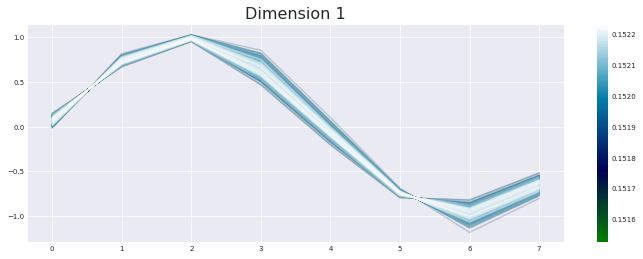

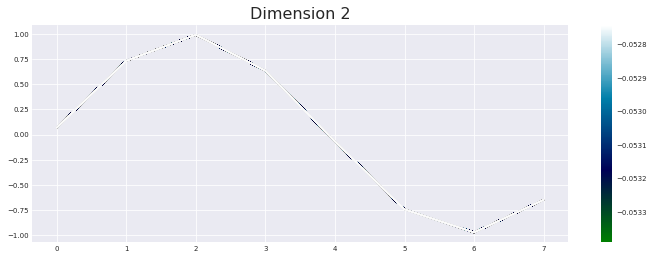

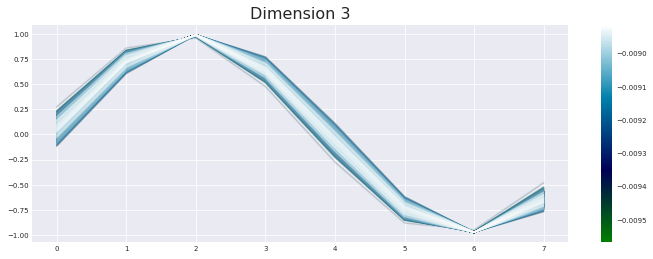

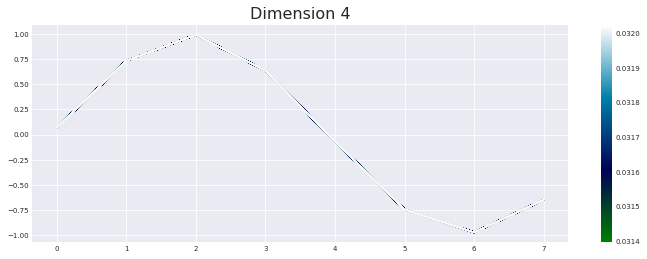

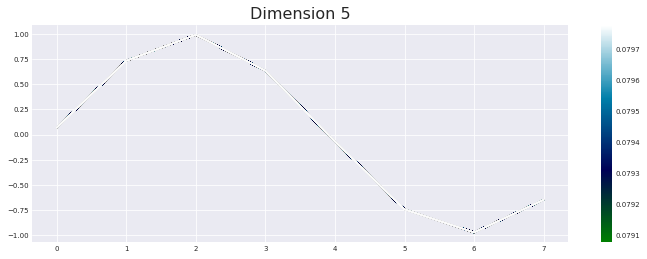

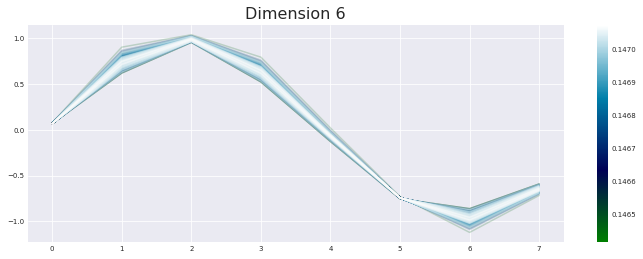

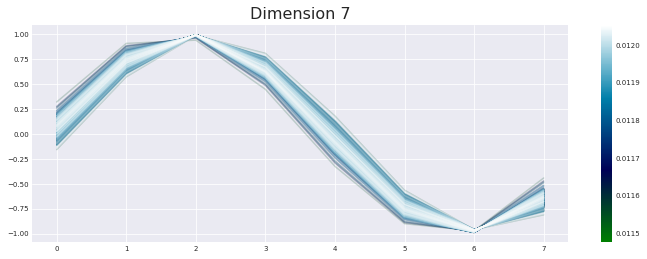

In [98]:
for i_feature in range(stds_per_dim.size()[1]):
    stds_cloned = stds_per_dim.clone()
    stds_cloned = stds_cloned * 0
    stds_cloned[0,i_feature] = stds_per_dim[0, i_feature]
    rec_examples = get_inputs_from_reverted_samples(
        len(inputs),means_per_dim, stds_cloned, weights_per_cluster, feature_model)
    i_sort = np.argsort(var_to_np(gauss_samples)[:, i_feature])
    sorted_examples = rec_examples[i_sort]
    plot_sorted_examples(sorted_examples)
    plt.title("Dimension {:d}".format(i_feature), fontsize=16)